# Postverdad — Entities Pack **B: Cobertura** (sin vistas)
Incluye dashboards:
1) **Top Entities** (volumen y cuota en el periodo)
2) **Tendencias temporales por entidad** (serie diaria/semanal)
5) **Cobertura medio × entidad** (matriz/pivote)
7) **Desglose por tipo de entidad** (PER/ORG/LOC, global y por medio)

**Uso**
1. Ajusta los **parámetros** debajo (fechas, tipos, medios, top-N).
2. Ejecuta todas las celdas (Kernel → Restart & Run All).
3. Repite con nuevos parámetros si deseas.

> Consulta directa a `articles`, `entities`, `articles_entities`, `sources` (no depende de vistas).


In [1]:
import os
import pandas as pd
import numpy as np
import psycopg2
from psycopg2.extras import RealDictCursor
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 20)

# Credenciales desde variables de entorno
PG = {
    "host": os.getenv("POSTGRES_HOST", "localhost"),
    "port": int(os.getenv("POSTGRES_PORT", "5432")),
    "dbname": os.getenv("POSTGRES_DB", "postverdad"),
    "user": os.getenv("POSTGRES_USER", "postverdad"),
    "password": os.getenv("POSTGRES_PASSWORD", "postverdad"),
}
PG

{'host': 'localhost',
 'port': 5432,
 'dbname': 'postverdad',
 'user': 'postverdad',
 'password': 'postverdad'}

## Parámetros

In [2]:
# Fechas (ISO YYYY-MM-DD)
END_DATE = pd.Timestamp.utcnow().date().isoformat()
START_DATE = (pd.Timestamp(END_DATE) - pd.Timedelta(days=90)).date().isoformat()

# Tipos de entidad a incluir ([] = todos)
ENTITY_TYPES = ['PER','ORG','LOC']  # o []

# Medios a incluir por nombre (tabla sources.name) ([] = todos)
SOURCES = []  # ejemplo: ['El Mostrador','La Tercera']

# Granularidad de tendencia: 'D' (diaria) o 'W' (semanal)
TREND_FREQ = 'D'

# Tamaños
TOP_ENTITIES = 50         # para top y matrices
TOP_TREND_ENTITIES = 10   # cuántas entidades graficar en tendencias
TOP_PER_SOURCE = 15       # # de entidades/columnas por medio en matriz

START_DATE, END_DATE, ENTITY_TYPES, SOURCES, TREND_FREQ

('2025-06-05', '2025-09-03', ['PER', 'ORG', 'LOC'], [], 'D')

In [3]:
def read_sql_df(query, params=None):
    conn = psycopg2.connect(**PG)
    try:
        with conn.cursor(cursor_factory=RealDictCursor) as cur:
            cur.execute(query, params or {})
            rows = cur.fetchall()
        return pd.DataFrame(rows)
    finally:
        conn.close()

## Carga base (articles × entities, con filtros)

In [4]:
def fetch_article_entities(start_date, end_date, entity_types=None, sources=None):
    entity_types = entity_types or []
    sources = sources or []
    sql = '''
        SELECT
          a.id   AS article_id,
          a.publication_date,
          s.name AS source,
          e.id   AS entity_id,
          e.name AS entity_name,
          e.type AS entity_type
        FROM articles a
        JOIN articles_entities ae ON ae.article_id = a.id
        JOIN entities e ON e.id = ae.entity_id
        LEFT JOIN sources s ON s.id = a.source_id
        WHERE a.publication_date >= %(start)s
          AND a.publication_date < (%(end)s::date + INTERVAL '1 day')
    '''
    params = {'start': start_date, 'end': end_date}
    if entity_types:
        sql += " AND e.type = ANY(%(types)s)"
        params['types'] = entity_types
    if sources:
        sql += " AND s.name = ANY(%(sources)s)"
        params['sources'] = sources
    sql += " ORDER BY a.publication_date DESC NULLS LAST"
    df = read_sql_df(sql, params)
    if not df.empty:
        df['publication_date'] = pd.to_datetime(df['publication_date'], errors='coerce')
    return df

df = fetch_article_entities(START_DATE, END_DATE, ENTITY_TYPES, SOURCES)
print(f"Filas cargadas: {len(df)}")
df.head(10)

Filas cargadas: 82204


,article_id,publication_date,source,entity_id,entity_name,entity_type
0,9364,2025-09-03,el_mostrador,94554,Juan Carlos Olmedo,PER
1,9388,2025-09-03,el_mostrador,840271,Lindísimas,PER
2,9388,2025-09-03,el_mostrador,3497,Bolivia,LOC
3,9387,2025-09-03,el_mostrador,840257,Ezra,PER
4,9387,2025-09-03,el_mostrador,266367,Jesús Diamantino,PER
5,9387,2025-09-03,el_mostrador,840253,Demoníaco,PER
6,9386,2025-09-03,el_mostrador,290882,Acompañarlos,PER
7,9386,2025-09-03,el_mostrador,145415,Ana María Tello,PER
8,9386,2025-09-03,el_mostrador,145417,Iplacex,PER
9,9386,2025-09-03,el_mostrador,832653,Andrea Correa,PER


### (Opcional) Deduplicación por (artículo, entidad)

In [5]:
# Si sospechas duplicados en articles_entities, activa esta línea:
# df = df.drop_duplicates(subset=['article_id','entity_id'])

## 1) Top Entities (volumen y cuota en periodo)

In [6]:
def top_entities(df, top_n=50):
    if df.empty:
        return pd.DataFrame(columns=['entity_name','entity_type','n','share_pct'])
    counts = (df.groupby(['entity_name','entity_type'])
                .size()
                .rename('n')
                .reset_index()
                .sort_values('n', ascending=False))
    total = counts['n'].sum()
    counts['share_pct'] = (100.0 * counts['n'] / max(total, 1)).round(2)
    return counts.head(top_n)

top_df = top_entities(df, TOP_ENTITIES)
top_df.head(20)

,entity_name,entity_type,n,share_pct
5838,Chile,LOC,1843,2.24
10333,El Mostrador,ORG,688,0.84
28186,Santiago,LOC,454,0.55
11187,Estado,LOC,454,0.55
11300,Estados Unidos,LOC,434,0.53
16693,Jeannette Jara,PER,362,0.44
13865,Gobierno,LOC,316,0.38
13318,Gabriel Boric,PER,275,0.33
17227,José Antonio Kast,PER,270,0.33
11510,Evelyn Matthei,PER,266,0.32


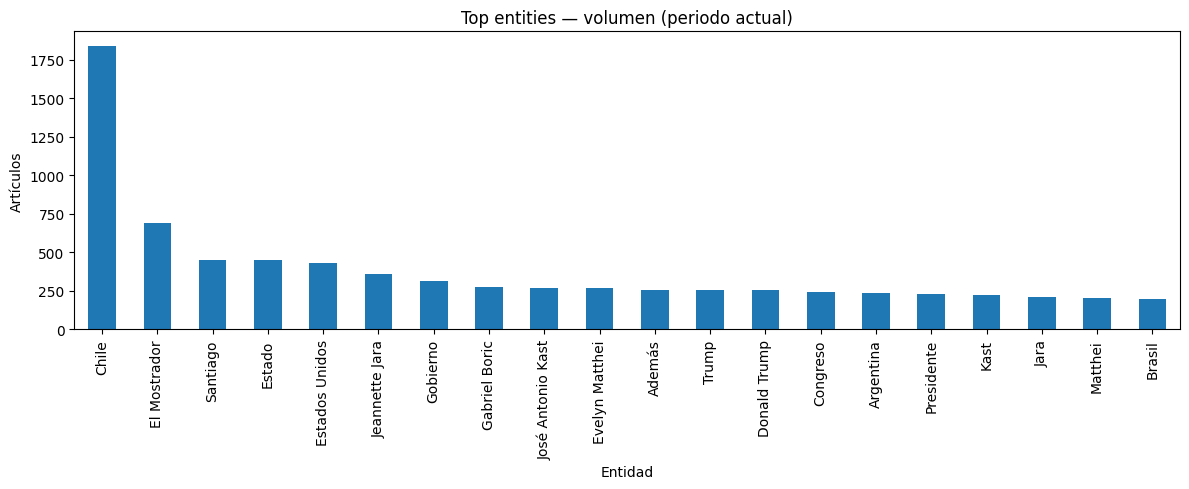

In [7]:
# Gráfico: Top 20 entidades por volumen
if not top_df.empty:
    ax = top_df.set_index('entity_name')['n'].head(20).plot(kind='bar', figsize=(12,5))
    ax.set_title('Top entities — volumen (periodo actual)')
    ax.set_xlabel('Entidad')
    ax.set_ylabel('Artículos')
    plt.tight_layout()
    plt.show()

## 2) Tendencias temporales por entidad

In [8]:
def entity_trends(df, top_entities, freq='D'):
    if df.empty or top_entities.empty:
        return pd.DataFrame()
    # series por entidad
    d = df.copy()
    d = d[d['entity_name'].isin(top_entities['entity_name'].head(TOP_TREND_ENTITIES))]
    d['period'] = d['publication_date'].dt.to_period(freq).dt.to_timestamp()
    ts = (d.groupby(['entity_name','period'])
            .size()
            .rename('n')
            .reset_index()
            .sort_values('period'))
    return ts

trends = entity_trends(df, top_df, TREND_FREQ)
trends.head(10)

,entity_name,period,n
0,Chile,2025-06-05,23
236,Estados Unidos,2025-06-05,6
314,Evelyn Matthei,2025-06-05,2
79,El Mostrador,2025-06-05,15
386,Gabriel Boric,2025-06-05,7
458,Gobierno,2025-06-05,5
674,Santiago,2025-06-05,6
534,Jeannette Jara,2025-06-05,1
158,Estado,2025-06-05,12
1,Chile,2025-06-06,31


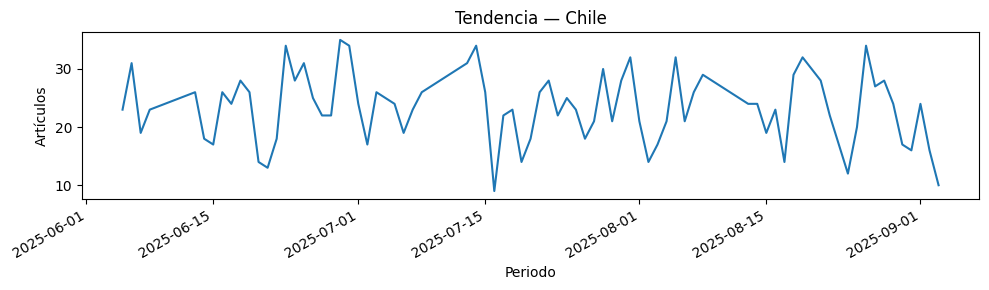

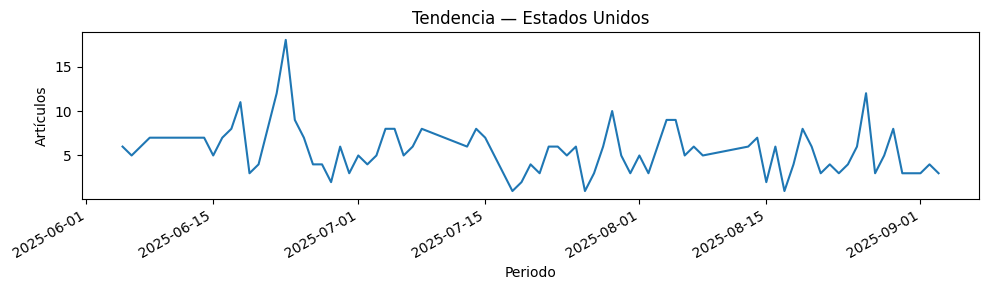

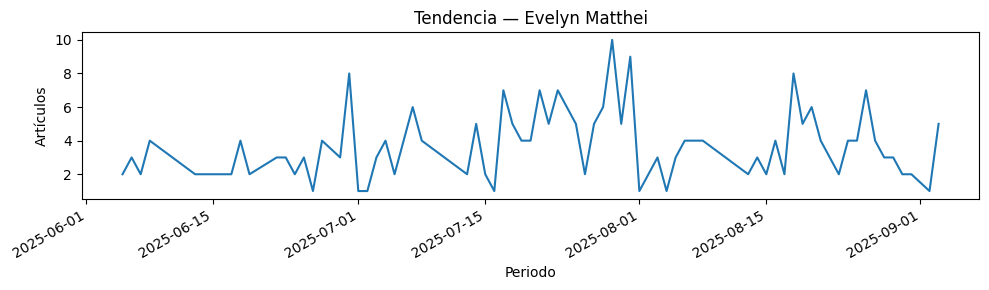

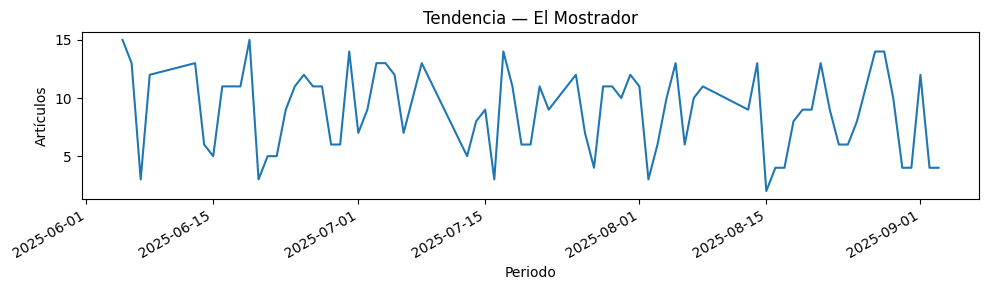

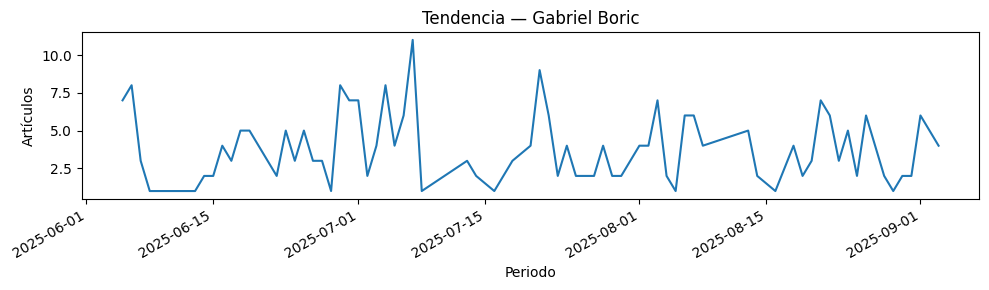

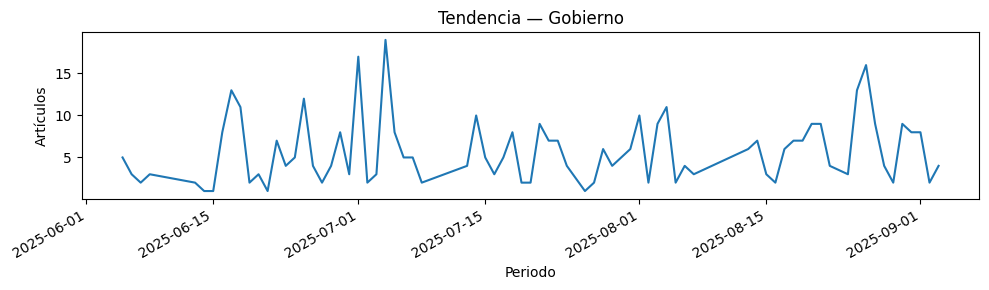

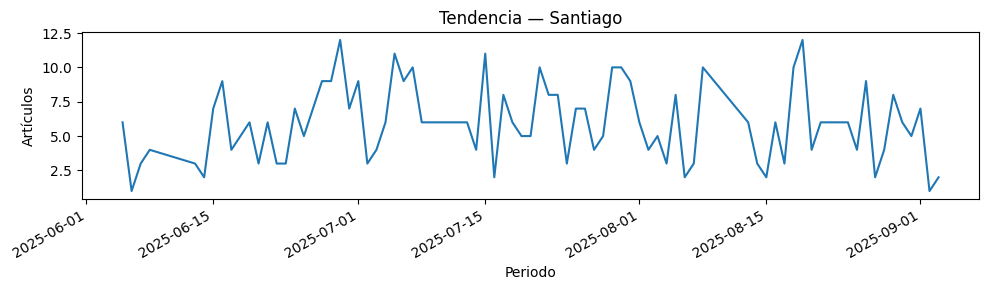

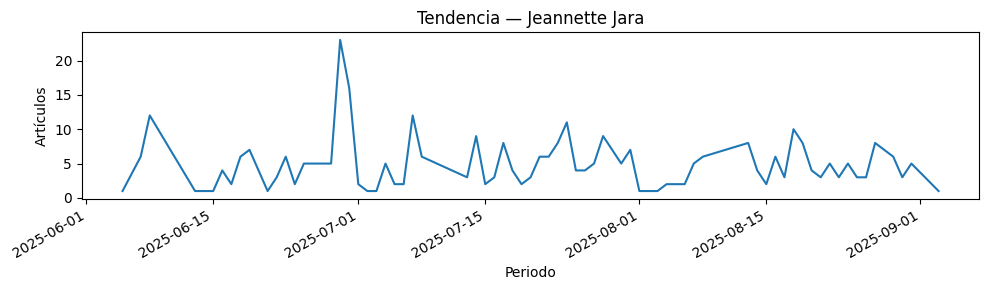

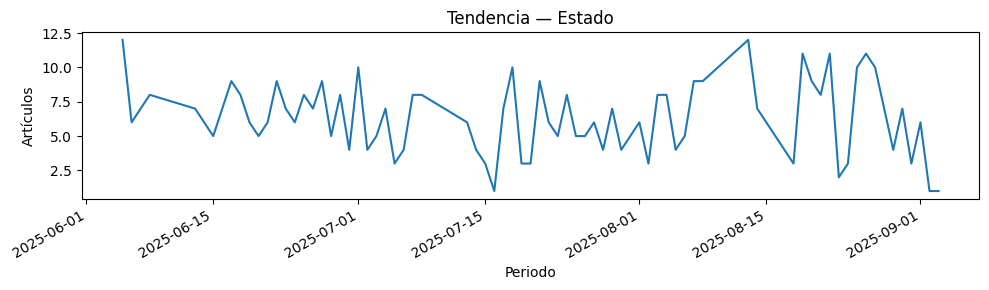

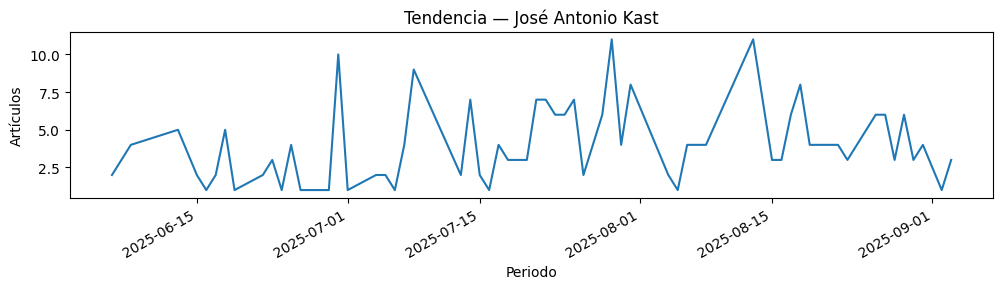

In [9]:
# Gráficos: una serie por entidad (hasta TOP_TREND_ENTITIES)
if not trends.empty:
    for ent in trends['entity_name'].unique():
        d = trends[trends['entity_name']==ent]
        ax = d.set_index('period')['n'].plot(figsize=(10,3))
        ax.set_title(f'Tendencia — {ent}')
        ax.set_xlabel('Periodo')
        ax.set_ylabel('Artículos')
        plt.tight_layout()
        plt.show()

## 5) Cobertura **medio × entidad** (matriz/pivote)

In [10]:
def coverage_matrix(df, top_entities, top_per_source=15):
    if df.empty or top_entities.empty:
        return pd.DataFrame()
    ents = top_entities['entity_name'].head(TOP_ENTITIES).tolist()
    sub = df[df['entity_name'].isin(ents)]
    piv = (sub.groupby(['source','entity_name'])
               .size()
               .rename('n')
               .reset_index()
               .pivot(index='source', columns='entity_name', values='n')
               .fillna(0)
               .astype(int))
    # recortar columnas a top global
    cols = (sub['entity_name'].value_counts().head(top_per_source).index)
    piv = piv.reindex(columns=cols, fill_value=0)
    return piv.sort_index()

cov_mat = coverage_matrix(df, top_df, TOP_PER_SOURCE)
cov_mat.head(10)

entity_name,Chile,El Mostrador,Estado,Santiago,Estados Unidos,Gobierno,Jeannette Jara,Jara,Además,Gabriel Boric,José Antonio Kast,Evelyn Matthei,Trump,Donald Trump,Chile Vamos
source,,,,,,,,,,,,,,,
el_mostrador,1841,709,491,466,434,434,362,302,286,275,270,266,260,256,256
example.com,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0


entity_name,Chile,El Mostrador,Estado,Santiago,Estados Unidos,Gobierno,Jeannette Jara,Jara,Además,Gabriel Boric,José Antonio Kast,Evelyn Matthei,Trump,Donald Trump,Chile Vamos
source,,,,,,,,,,,,,,,
el_mostrador,1841,709,491,466,434,434,362,302,286,275,270,266,260,256,256
example.com,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0


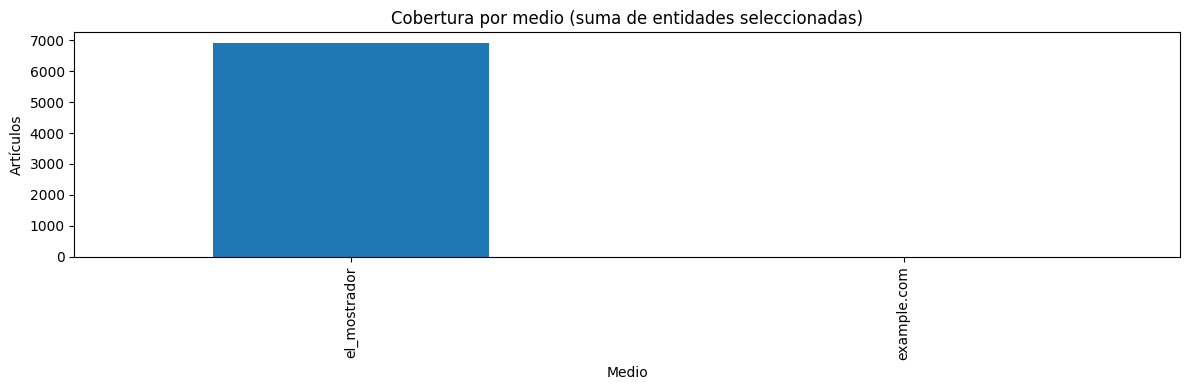

In [11]:
# Mostrar matriz (tabla); y barras por fuente (suma de fila)
if not cov_mat.empty:
    display(cov_mat)
    sums = cov_mat.sum(axis=1).sort_values(ascending=False)
    ax = sums.plot(kind='bar', figsize=(12,4))
    ax.set_title('Cobertura por medio (suma de entidades seleccionadas)')
    ax.set_xlabel('Medio')
    ax.set_ylabel('Artículos')
    plt.tight_layout()
    plt.show()

## 7) Desglose por **tipo de entidad** (global y por medio)

In [12]:
def breakdown_by_type(df):
    if df.empty:
        return pd.DataFrame(columns=['entity_type','n','share_pct'])
    g = (df.groupby('entity_type').size().rename('n').reset_index().sort_values('n', ascending=False))
    total = g['n'].sum()
    g['share_pct'] = (100.0 * g['n'] / max(total, 1)).round(2)
    return g

types_global = breakdown_by_type(df)
types_global

,entity_type,n,share_pct
0,LOC,31156,37.90
2,PER,30950,37.65
1,ORG,20098,24.45


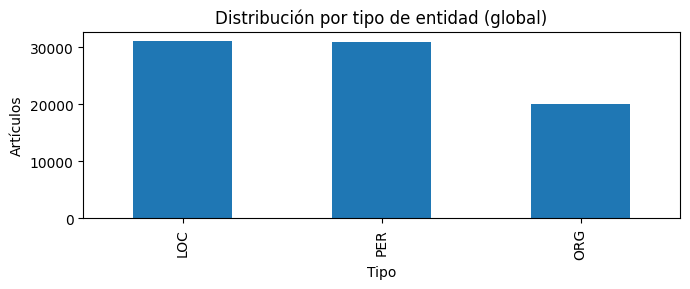

In [13]:
# Gráfico global
if not types_global.empty:
    ax = types_global.set_index('entity_type')['n'].plot(kind='bar', figsize=(7,3))
    ax.set_title('Distribución por tipo de entidad (global)')
    ax.set_xlabel('Tipo')
    ax.set_ylabel('Artículos')
    plt.tight_layout()
    plt.show()

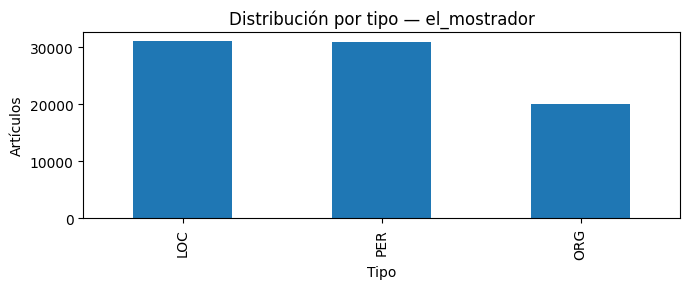

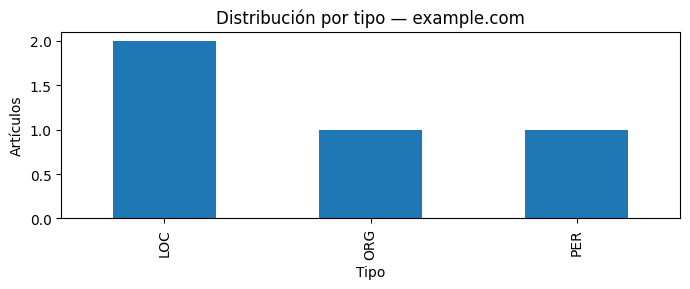

In [14]:
# Por medio (top 10 por volumen)
if not df.empty:
    top_sources = df['source'].value_counts().head(10).index
    for src in top_sources:
        sub = df[df['source']==src]
        tb = breakdown_by_type(sub)
        if tb.empty:
            continue
        ax = tb.set_index('entity_type')['n'].plot(kind='bar', figsize=(7,3))
        ax.set_title(f'Distribución por tipo — {src}')
        ax.set_xlabel('Tipo')
        ax.set_ylabel('Artículos')
        plt.tight_layout()
        plt.show()